# 5.0 - Model Training, Evaluation, and Business Simulation

_by Michael Joshua Vargas_

This notebook implements the full machine learning workflow. It covers:
1.  **Data Preparation**: Loading the final feature set and splitting it into training, validation, and holdout sets.
2.  **Preprocessing**: Creating a robust pipeline to scale numerical features and one-hot encode categorical features.
3.  **Model Tuning**: Training and tuning two separate XGBoost models optimized for different business goals (Precision and AUC-PR).
4.  **Business Evaluation**: Using the tuned models on the holdout set to simulate a real-world, cost-sensitive fraud detection system.

## 1. Setup and Data Preparation

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

#### 1.1. Import relevant libraries

In [2]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import warnings
from collections import Counter
import math

# --- Preprocessing & Modeling ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# --- Evaluation ---
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    balanced_accuracy_score,
    f1_score,
    matthews_corrcoef,
    brier_score_loss
)
from IPython.display import display # Added for display function

# --- Model Persistence & Visualization ---
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
# --- Path Setup ---
# Get the current working directory of the notebook
notebook_dir = Path(os.getcwd())

# Navigate up one level to reach the project root directory
project_root = notebook_dir.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# --- Custom Plotting Functions ---
from bank_fraud.utils.visualizations import plot_confusion_matrix, plot_feature_importance, plot_beeswarm

# Import from config.py
from bank_fraud.config import PROCESSED_DATA_DIR, REFERENCES_DIR, MODELS_DIR, REPORTS_DIR, REPORTS_FIGURES_DIR, REPORTS_MODEL_EVAL_DIR

### 1.2. Load Final Dataset

In [4]:
# Load the final, curated dataset from the feature selection phase
FINAL_DATA_PATH = PROCESSED_DATA_DIR / '3.0_selected_features.parquet'
df = pd.read_parquet(FINAL_DATA_PATH)

print(f"Dataset loaded successfully from: {FINAL_DATA_PATH.relative_to(project_root)}")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully from: data\processed\3.0_selected_features.parquet
Dataset shape: (493189, 65)


### 1.3. Identify Feature Types and Define Target

In [5]:
# --- Dynamically Drop Identifier Columns ---

# Load the identifier data dictionary to get the authoritative list of identifiers
IDENTIFIER_DICT_PATH = REFERENCES_DIR / 'identifier_data_dictionary.csv'
identifier_df = pd.read_csv(IDENTIFIER_DICT_PATH)
all_identifiers = identifier_df['feature_name'].tolist()

# Find which of these identifiers are actually present in our current DataFrame
# This ensures the script doesn't fail if a column was already dropped in a previous step.
identifiers_to_drop = [col for col in all_identifiers if col in df.columns]

# Define the target variable
TARGET_COL = 'fraud_status'

# Define the feature matrix X by dropping the target and all identified identifiers
X = df.drop(columns=[TARGET_COL] + identifiers_to_drop, errors='ignore')
y = df[TARGET_COL]

print(f"Dropped {len(identifiers_to_drop)} identifier columns: {identifiers_to_drop}")


# Identify numerical and categorical features from the final feature matrix X
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Identified {len(numerical_features)} numerical features.")
print(f"Identified {len(categorical_features)} categorical features.")

Dropped 2 identifier columns: ['profile_id', 'account_no']
Identified 59 numerical features.
Identified 3 categorical features.


### 1.4. Split Data into Training, Validation, and Holdout Sets

#### 1.4.1. Data Splitting Strategy: A Note on Time-Based vs. Stratified Splitting

**The Gold Standard vs. Practical Reality**

For fraud detection, the "gold standard" for model validation is a **time-based split**. This involves training the model on older data and validating it on a holdout set of the most recent data (e.g., train on Jan-Apr, test on May). This method best simulates a real-world deployment scenario where a model predicts on future, unseen transactions.

**The Challenge: Extreme Class Imbalance**

Initial attempts to implement a time-based split, particularly for cross-validation within the training set, encountered a critical issue. Due to the extreme rarity of fraud cases in the dataset, this approach frequently resulted in one or more cross-validation folds containing **zero instances of the minority (fraud) class**.

This instability has a severe consequence: it makes it impossible to calculate essential performance metrics like Precision, Recall, and AUC-PR, as these metrics rely on the presence of positive cases. Without these scores, the hyperparameter tuning process (`GridSearchCV` and `RandomizedSearchCV`) cannot compare different models and effectively breaks down.

**The Pragmatic Solution: Stratified Splitting**

To ensure a robust and stable model training and evaluation process, we have made the deliberate decision to use a **stratified split** instead.

*   **What it does:** Stratified splitting ensures that the proportion of fraud and non-fraud cases is identical across the training, validation, and holdout sets, as well as within each fold of our cross-validation.
*   **Why it's better here:** This guarantees that every single evaluation, at every step, is performed on a dataset with a consistent and representative fraud rate. This allows for the stable calculation of all performance metrics, enabling a reliable hyperparameter tuning process.

While this approach does not perfectly mirror a real-world time-series deployment, it is the necessary and methodologically sound choice that allows us to build and tune the best possible model given the constraints of the data.

We will perform a stratified split to ensure the proportion of fraud cases is consistent across all datasets.
- **Training Set (70%)**: For training the model.
- **Validation Set (15%)**: For tuning hyperparameters.
- **Holdout Set (15%)**: For final, unbiased evaluation.

In [6]:
# First split: Separate the 30% holdout set from the rest (70% for train+val)
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y,
    test_size=0.30,  # 30% for holdout
    random_state=143,
    shuffle=False
)

# Second split: Split the 70% train+val set into validation (15%) and training (55%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    test_size=0.50, 
    random_state=143, 
    shuffle=False
)

print("Data splitting complete.")
print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Holdout set shape:    {X_holdout.shape}")
print("\nProportion of fraud in each set:")
print(f"Training:   {y_train.mean():.4f}")
print(f"Validation: {y_val.mean():.4f}")
print(f"Holdout:    {y_holdout.mean():.4f}")

Data splitting complete.
Training set shape:   (172616, 62)
Validation set shape: (172616, 62)
Holdout set shape:    (147957, 62)

Proportion of fraud in each set:
Training:   0.0166
Validation: 0.0169
Holdout:    0.0162


### 1.5 Establish Baseline with Proportion Chance Criterion (PCC)

Before building complex models, it's crucial to establish a baseline to understand the minimum performance we must exceed. For imbalanced classification tasks, simple accuracy can be misleading. The **Proportion Chance Criterion (PCC)** provides this baseline.

The PCC represents the accuracy a naive model would achieve by always guessing the majority class. A common rule of thumb is that a useful model's accuracy should be at least 25% greater than the PCC.

This calculation will demonstrate why we focus on metrics like Precision, Recall, and AUC-PR instead of accuracy alone.

In [7]:
from collections import Counter

# Calculate PCC on the training data
class_counts = Counter(y_train)
total_samples = len(y_train)

pcc = ((class_counts[0] / total_samples)**2) + ((class_counts[1] / total_samples)**2)
pcc_threshold = 1.25 * pcc

print(f"Proportion Chance Criterion (PCC): {pcc:.2%}")
print(f"1.25 * PCC Threshold: {pcc_threshold:.2%}")

Proportion Chance Criterion (PCC): 96.73%
1.25 * PCC Threshold: 120.91%


**Interpretation:**

The PCC of approximately 0.97 indicates that a model that does nothing but predict 'NON_FRAUD' for every case would be about 97% accurate. This high value underscores the inadequacy of accuracy as a primary metric for this problem. Our model must demonstrate a much more nuanced understanding of the data to be considered effective, which is why our evaluation will focus on its ability to correctly identify the rare fraud cases (Precision and Recall).

## 2. Preprocessing Pipeline Construction

We will create a preprocessing pipeline using `ColumnTransformer` to apply different transformations to different types of columns.

- **Numerical Features**: Will be scaled using `StandardScaler`. This standardizes features by removing the mean and scaling to unit variance, which is crucial for the performance of many machine learning algorithms.
- **Categorical Features**: Will be transformed using `OneHotEncoder`. This converts categorical variables into a numerical format that can be provided to the model. `handle_unknown='ignore'` ensures that if a new category appears in the validation or holdout data (that was not seen in the training data), it will be handled gracefully without causing an error.

In [8]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep other columns (if any), though we expect none
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


## 3. Model Training and Evaluation

### 3.1. Baseline Model Comparison (No Resampling)

We will first evaluate a set of baseline models without any resampling techniques to establish a performance benchmark.
This step helps us understand the inherent performance of different algorithms on our imbalanced dataset.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time

def auto_ml(X, y, models_dict, preprocessor, cv, res_t=None):
    """
    Applies preprocessing, optional resampling, and evaluates multiple models using cross-validation.
    """
    results = {}
    results_formatted = {}

    for model_name, model_instance in models_dict.items():
        print(f"\n--- Evaluating {model_name} ---")
        
        # Create a pipeline that includes preprocessing and the model
        if res_t is not None:
            # If resampling is applied, use ImbPipeline
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('resampler', res_t),
                ('classifier', model_instance)
            ])
        else:
            # Otherwise, use standard Pipeline
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model_instance)
            ])

        train_ap, val_ap = [], []
        train_bal_acc, val_bal_acc = [], []
        train_f1_w, val_f1_w = [], []
        train_mcc, val_mcc = [], []
        train_brier, val_brier = [], []
        train_precision, val_precision = [], []
        train_recall, val_recall = [], []
        
        fold_times = []

        for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            start_time = time.time()
            pipeline.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            fold_times.append(end_time - start_time)

            # Predictions
            train_preds = pipeline.predict(X_train_fold)
            val_preds = pipeline.predict(X_val_fold)
            
            # Predict probabilities for metrics that require them
            train_probas = pipeline.predict_proba(X_train_fold)[:, 1]
            val_probas = pipeline.predict_proba(X_val_fold)[:, 1]

            # Calculate metrics
            train_ap.append(average_precision_score(y_train_fold, train_probas))
            val_ap.append(average_precision_score(y_val_fold, val_probas))

            train_bal_acc.append(balanced_accuracy_score(y_train_fold, train_preds))
            val_bal_acc.append(balanced_accuracy_score(y_val_fold, val_preds))

            train_f1_w.append(f1_score(y_train_fold, train_preds, average='weighted'))
            val_f1_w.append(f1_score(y_val_fold, val_preds, average='weighted'))

            train_mcc.append(matthews_corrcoef(y_train_fold, train_preds))
            val_mcc.append(matthews_corrcoef(y_val_fold, val_preds))
            
            train_brier.append(brier_score_loss(y_train_fold, train_probas))
            val_brier.append(brier_score_loss(y_val_fold, val_probas))

            train_precision.append(precision_score(y_train_fold, train_preds))
            val_precision.append(precision_score(y_val_fold, val_preds))

            train_recall.append(recall_score(y_train_fold, train_preds))
            val_recall.append(recall_score(y_val_fold, val_preds))

        # Store average results
        results[model_name] = {
            'Train AP': np.mean(train_ap),
            'Val AP': np.mean(val_ap),
            'Train BalAcc': np.mean(train_bal_acc),
            'Val BalAcc': np.mean(val_bal_acc),
            'Train F1_w': np.mean(train_f1_w),
            'Val F1_w': np.mean(val_f1_w),
            'Train MCC': np.mean(train_mcc),
            'Val MCC': np.mean(val_mcc),
            'Train Brier': np.mean(train_brier),
            'Val Brier': np.mean(val_brier),
            'Train Precision': np.mean(train_precision),
            'Val Precision': np.mean(val_precision),
            'Train Recall': np.mean(train_recall),
            'Val Recall': np.mean(val_recall),
            'Avg Run Time (s)': np.mean(fold_times)
        }
        
        # Store formatted results
        results_formatted[model_name] = {
            'Train AP': f"{np.mean(train_ap)*100:.2f}%",
            'Val AP': f"{np.mean(val_ap)*100:.2f}%",
            'Train BalAcc': f"{np.mean(train_bal_acc)*100:.2f}%",
            'Val BalAcc': f"{np.mean(val_bal_acc)*100:.2f}%",
            'Train F1_w': f"{np.mean(train_f1_w)*100:.2f}%",
            'Val F1_w': f"{np.mean(val_f1_w)*100:.2f}%",
            'Train MCC': f"{np.mean(train_mcc):.4f}",
            'Val MCC': f"{np.mean(val_mcc):.4f}",
            'Train Brier': f"{np.mean(train_brier):.4f}",
            'Val Brier': f"{np.mean(val_brier):.4f}",
            'Train Precision': f"{np.mean(train_precision)*100:.2f}%",
            'Val Precision': f"{np.mean(val_precision)*100:.2f}%",
            'Train Recall': f"{np.mean(train_recall)*100:.2f}%",
            'Val Recall': f"{np.mean(val_recall)*100:.2f}%",
            'Avg Run Time (s)': f"{np.mean(fold_times):.2f}"
        }

    return pd.DataFrame(results).T, pd.DataFrame(results_formatted).T

In [10]:
# Define baseline models
# For XGBoost, scale_pos_weight is calculated based on the training data imbalance
# eval_metric is set to 'logloss' for general classification, but AUC-PR is also tracked
models_dict = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=143),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143, class_weight='balanced', max_depth=8, min_samples_leaf=20, ccp_alpha=0.001),
    'XGBoost': XGBClassifier(
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
        eval_metric='logloss', # Use logloss for general evaluation, AUC-PR is tracked separately
        random_state=143
    )
}

In [11]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

# --- Conditional Baseline Evaluation ---

baseline_results_path = REPORTS_MODEL_EVAL_DIR / 'baseline_model_performance.csv'

if baseline_results_path.exists():
    print("\n--- Loading Pre-computed Baseline Model Performance ---")
    baseline_results_formatted = pd.read_csv(baseline_results_path, index_col=0)
    display(baseline_results_formatted)
else:
    print("\n--- Running Baseline Model Evaluation (No Resampling) ---")
    # Run baseline evaluation
    baseline_results, baseline_results_formatted = auto_ml(X_train, y_train, models_dict, preprocessor, cv)
    
    # Save baseline results
    baseline_results_formatted.to_csv(baseline_results_path, index=True)
    print(f"\nBaseline model performance saved to: {baseline_results_path.relative_to(project_root)}")
    
    print("\n--- Baseline Model Performance (No Resampling) ---")
    display(baseline_results_formatted)


--- Loading Pre-computed Baseline Model Performance ---


,Train AP,Val AP,Train BalAcc,Val BalAcc,Train F1_w,Val F1_w,Train MCC,Val MCC,Train Brier,Val Brier,Train Precision,Val Precision,Train Recall,Val Recall,Avg Run Time (s)
LogisticRegression,54.59%,53.99%,79.67%,79.39%,96.59%,96.59%,0.3511,0.3483,0.1001,0.1003,21.42%,21.30%,63.27%,62.71%,2.30
GaussianNB,20.15%,20.17%,75.76%,75.75%,97.32%,97.32%,0.3674,0.3672,0.0317,0.0318,26.99%,26.97%,53.99%,53.97%,0.65
DecisionTreeClassifier,30.97%,30.11%,79.10%,78.26%,96.87%,96.82%,0.3652,0.3549,0.1043,0.1049,23.69%,23.11%,61.63%,59.99%,2.19
XGBoost,70.81%,53.97%,84.88%,77.11%,98.69%,98.21%,0.6289,0.4908,0.0713,0.0752,57.42%,45.41%,70.69%,55.40%,2.04


### 3.2. Resampling Techniques Evaluation

Now, we will evaluate the impact of different resampling techniques on model performance.
We will compare RandomOverSampler, SMOTE, and RandomUnderSampler.

In [12]:
# --- Conditional Resampling Evaluation ---

resampling_results_path = REPORTS_MODEL_EVAL_DIR / 'resampling_model_performance.csv'

resamplers_dict = {
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42)
}

if resampling_results_path.exists():
    print("\n--- Loading Pre-computed Resampling Model Performance ---")
    resampling_results_formatted_df = pd.read_csv(resampling_results_path, index_col=0)
    display(resampling_results_formatted_df)
else:
    print("\n--- Running Resampling Model Evaluation ---")
    resampling_results = {}
    resampling_results_formatted = {}

    for resampler_name, resampler_instance in resamplers_dict.items():
        print(f"\n--- Evaluating with {resampler_name} ---")
        # For each resampler, evaluate all models
        current_res_results, current_res_results_formatted = auto_ml(X_train, y_train, models_dict, preprocessor, cv, res_t=resampler_instance)
        
        # Store results, potentially renaming columns to indicate resampler
        for model_name in current_res_results.index:
            # Use a combined key for model and resampler
            combined_key = f"{model_name} + {resampler_name}"
            resampling_results[combined_key] = current_res_results.loc[model_name].to_dict()
            resampling_results_formatted[combined_key] = current_res_results_formatted.loc[model_name].to_dict()

    resampling_results_df = pd.DataFrame(resampling_results).T
    resampling_results_formatted_df = pd.DataFrame(resampling_results_formatted).T

    # Save resampling results
    resampling_results_formatted_df.to_csv(resampling_results_path, index=True)
    print(f"\nResampling model performance saved to: {resampling_results_path.relative_to(project_root)}")

    print("\n--- Model Performance with Resampling ---")
    display(resampling_results_formatted_df)


--- Loading Pre-computed Resampling Model Performance ---


,Train AP,Val AP,Train BalAcc,Val BalAcc,Train F1_w,Val F1_w,Train MCC,Val MCC,Train Brier,Val Brier,Train Precision,Val Precision,Train Recall,Val Recall,Avg Run Time (s)
LogisticRegression + RandomOverSampler,54.59%,54.03%,79.68%,79.39%,96.59%,96.58%,0.3512,0.3481,0.1001,0.1002,21.42%,21.28%,63.29%,62.71%,4.85
GaussianNB + RandomOverSampler,19.93%,19.93%,75.90%,75.90%,97.27%,97.28%,0.3645,0.3645,0.0326,0.0325,26.43%,26.45%,54.37%,54.35%,1.12
DecisionTreeClassifier + RandomOverSampler,31.04%,30.14%,79.11%,78.29%,96.93%,96.87%,0.3690,0.3581,0.1040,0.1046,24.14%,23.46%,61.54%,59.96%,4.37
XGBoost + RandomOverSampler,69.83%,50.20%,66.69%,59.37%,49.31%,48.74%,0.0909,0.0511,0.5676,0.5732,2.48%,2.12%,100.00%,85.76%,4.43
LogisticRegression + SMOTE,54.92%,54.36%,79.62%,79.11%,94.65%,94.66%,0.3163,0.3102,0.1009,0.1011,18.23%,17.86%,66.58%,65.49%,5.00
GaussianNB + SMOTE,19.91%,19.93%,75.94%,75.93%,97.26%,97.26%,0.3635,0.3631,0.0328,0.0329,26.26%,26.21%,54.47%,54.46%,1.57
DecisionTreeClassifier + SMOTE,24.58%,24.36%,76.76%,76.47%,97.82%,97.82%,0.4287,0.4263,0.0888,0.0889,35.16%,35.14%,55.25%,54.67%,9.38
XGBoost + SMOTE,58.34%,48.44%,67.27%,60.08%,51.02%,50.47%,0.0930,0.0544,0.5532,0.5583,2.53%,2.17%,99.58%,85.62%,5.06
LogisticRegression + RandomUnderSampler,50.51%,49.52%,79.54%,79.24%,96.38%,96.37%,0.3384,0.3352,0.1025,0.1027,20.03%,19.87%,63.36%,62.78%,0.55
GaussianNB + RandomUnderSampler,16.92%,17.15%,75.87%,76.02%,96.90%,96.90%,0.3354,0.3374,0.0387,0.0386,22.53%,22.66%,54.94%,55.22%,0.49


### 3.3. Decision on Resampling and Final Model Selection

Based on the comparison of baseline models and models with resampling, we have made the following observations and decisions:

**Analysis of Baseline Models (No Resampling):**
- **XGBoost** continues to be the standout performer. It achieves a `Val AP` (Average Precision) of **53.97%** and a `Val Precision` of **45.41%**. Its `Val Recall` is **55.40%**, and its balanced accuracy (`Val BalAcc`) of **77.11%** and Matthews Correlation Coefficient (MCC) of **0.4908** indicate a good balance between identifying fraud and minimizing false positives.
- Other models (Logistic Regression, GaussianNB, Decision Tree Classifier) show significantly lower `Val Precision` and `Val AP` compared to XGBoost, confirming XGBoost as the most suitable base model.

**Analysis of Resampling Techniques:**
- For **XGBoost**, applying external resampling techniques (`RandomOverSampler`, `SMOTE`, `RandomUnderSampler`) consistently leads to a **drastic reduction in `Val Precision` (dropping to around 2%)**. While `Val Recall` significantly increases (up to **94.32%** with RandomUnderSampler), this comes at an unacceptable cost to precision, which is critical for minimizing false positives in the auto-blocking leg. The `Val AP` also generally decreases with resampling for XGBoost.
- For other models, resampling generally improves recall but often with a trade-off in precision and AP, and none achieve the overall balance of performance seen with XGBoost without external resampling.

**Decision on Resampling and Final Model Selection:**
- We will proceed with **XGBoost without an explicit external resampling technique** for hyperparameter tuning. The `scale_pos_weight` parameter within XGBoost itself is already effectively handling the class imbalance by giving more importance to the minority class during training.
- The results clearly show that external resampling, while boosting recall, severely compromises precision for XGBoost, making it unsuitable for our primary objective of minimizing false positives in the auto-blocking leg.
- This approach has consistently demonstrated the best balance between Precision and AUC-PR in our evaluations.

Our primary optimization targets for tuning will remain:
- **Precision**: Crucial for the "Auto-Blocking Leg" to minimize false positives.
- **Average Precision (AUC-PR)**: A robust metric for overall ranking quality in imbalanced datasets, important for both legs of the deployment.

In [13]:
# Placeholder for decision and next steps
print("\nReview the tables above and the saved CSV files to compare model performance with and without resampling.")
print("Based on Precision and AUC-PR, decide which combination (model + optional resampler) to proceed with for hyperparameter tuning.")
print("This decision will inform the next steps in the notebook.")


Review the tables above and the saved CSV files to compare model performance with and without resampling.
Based on Precision and AUC-PR, decide which combination (model + optional resampler) to proceed with for hyperparameter tuning.
This decision will inform the next steps in the notebook.


### 3.5. Hyperparameter Tuning for XGBoost

We will use a two-stage hyperparameter tuning process:
1.  **Stage 1: RandomizedSearchCV**: To efficiently explore a broad range of hyperparameters and identify promising regions.
2.  **Stage 2: GridSearchCV**: To perform a more exhaustive search within the narrowed, promising regions found by RandomizedSearchCV.

We will perform this two-stage tuning for two separate objectives: one optimized for Precision and another for AUC-PR.

In [14]:
# --- Define Paths for Granular Checkpoints ---
# Each stage of the tuning process will have its own results (CSV) and model (.joblib) file.

# Stage 1: Initial Randomized Search
rs_stage1_precision_results_path = REPORTS_MODEL_EVAL_DIR / 'random_search_stage1_precision_results.csv'
rs_stage1_precision_model_path = MODELS_DIR / 'random_search_stage1_precision_model.joblib'
rs_stage1_aucpr_results_path = REPORTS_MODEL_EVAL_DIR / 'random_search_stage1_aucpr_results.csv'
rs_stage1_aucpr_model_path = MODELS_DIR / 'random_search_stage1_aucpr_model.joblib'

# Stage 2: Wide Randomized Search
rs_stage2_precision_results_path = REPORTS_MODEL_EVAL_DIR / 'random_search_stage2_precision_results.csv'
rs_stage2_precision_model_path = MODELS_DIR / 'random_search_stage2_precision_model.joblib'
rs_stage2_aucpr_results_path = REPORTS_MODEL_EVAL_DIR / 'random_search_stage2_aucpr_results.csv'
rs_stage2_aucpr_model_path = MODELS_DIR / 'random_search_stage2_aucpr_model.joblib'

# Final best models
final_precision_model_path = MODELS_DIR / 'best_xgb_precision_model.joblib'
final_aucpr_model_path = MODELS_DIR / 'best_xgb_aucpr_model.joblib'


# --- Utility Functions for Displaying Results ---
def print_formatted_params(params, indent=4):
    """Prints dictionary parameters in a formatted way."""
    prefix = ' ' * indent
    for key, value in params.items():
        print(f"{prefix}{key}: {value}")

def clean_and_get_params(param_string):
    """Evaluates the param string and cleans the classifier__ prefix."""
    import ast
    try:
        param_dict = ast.literal_eval(param_string)
        return {k.replace('classifier__', ''): v for k, v in param_dict.items()}
    except (ValueError, SyntaxError):
        return {} # Return empty dict if parsing fails

# --- Summary of Tuning Progress ---
print("\n--- Summary of Hyperparameter Tuning Progress ---")

def display_stage_summary(stage_name, results_path):
    print(f"\n--- {stage_name} ---")
    try:
        df = pd.read_csv(results_path)
        if not df.empty and 'rank_test_score' in df.columns:
            best_row = df.loc[df['rank_test_score'] == 1].iloc[0]
            metric_name = 'Precision' if 'precision' in stage_name.lower() else 'AUC-PR'
            print(f"Best {metric_name} Score: {best_row['mean_test_score']:.4f}")
            print("Best Parameters:")
            params = clean_and_get_params(best_row['params'])
            print_formatted_params(params)
        else:
            print("Results file is empty or invalid.")
    except (FileNotFoundError, IndexError):
        print("Results not found. This stage has not been run yet.")

display_stage_summary("Stage 1: Randomized Search (Precision)", rs_stage1_precision_results_path)
display_stage_summary("Stage 1: Randomized Search (AUC-PR)", rs_stage1_aucpr_results_path)
display_stage_summary("Stage 2: Wide Randomized Search (Precision)", rs_stage2_precision_results_path)
display_stage_summary("Stage 2: Wide Randomized Search (AUC-PR)", rs_stage2_aucpr_results_path)


# --- Model and Pipeline Setup ---
# Define the XGBoost model instance (without external resampler, as decided)
xgb_model_for_tuning = models_dict['XGBoost']

# Create a pipeline for tuning that includes the preprocessor and the XGBoost model
pipeline_for_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model_for_tuning)
])

# --- Stage 1: Initial RandomizedSearchCV ---
print("\n\n--- Initiating Hyperparameter Tuning Stages ---")

# Define a broader parameter distribution for RandomizedSearchCV
param_distributions_stage1 = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.3],
    'classifier__reg_alpha': [0, 0.001, 0.01, 0.1], # L1 regularization
    'classifier__reg_lambda': [0, 0.001, 0.01, 0.1] # L2 regularization
}

# --- Stage 1: Randomized Search for Precision ---
if not rs_stage1_precision_results_path.exists() or not rs_stage1_precision_model_path.exists():
    print("\n--- Stage 1: Running Randomized Search for Precision ---")
    random_search_precision = RandomizedSearchCV(
        estimator=pipeline_for_tuning,
        param_distributions=param_distributions_stage1,
        n_iter=50,
        scoring='precision',
        cv=cv,
        verbose=2,
        random_state=143,
        n_jobs=-1
    )
    random_search_precision.fit(X_train, y_train)

    # Save results and best model
    pd.DataFrame(random_search_precision.cv_results_).to_csv(rs_stage1_precision_results_path, index=False)
    joblib.dump(random_search_precision.best_estimator_, rs_stage1_precision_model_path)
    print(f"Stage 1 (Precision) results saved to: {rs_stage1_precision_results_path.relative_to(project_root)}")
    print(f"Stage 1 (Precision) best model saved to: {rs_stage1_precision_model_path.relative_to(project_root)}")
else:
    print("\n--- Stage 1: Skipping Randomized Search for Precision (results already exist) ---")


# --- Stage 1: Randomized Search for AUC-PR ---
if not rs_stage1_aucpr_results_path.exists() or not rs_stage1_aucpr_model_path.exists():
    print("\n--- Stage 1: Running Randomized Search for AUC-PR ---")
    random_search_aucpr = RandomizedSearchCV(
        estimator=pipeline_for_tuning,
        param_distributions=param_distributions_stage1,
        n_iter=50,
        scoring='average_precision',
        cv=cv,
        verbose=2,
        random_state=143,
        n_jobs=-1
    )
    random_search_aucpr.fit(X_train, y_train)

    # Save results and best model
    pd.DataFrame(random_search_aucpr.cv_results_).to_csv(rs_stage1_aucpr_results_path, index=False)
    joblib.dump(random_search_aucpr.best_estimator_, rs_stage1_aucpr_model_path)
    print(f"Stage 1 (AUC-PR) results saved to: {rs_stage1_aucpr_results_path.relative_to(project_root)}")
    print(f"Stage 1 (AUC-PR) best model saved to: {rs_stage1_aucpr_model_path.relative_to(project_root)}")
else:
    print("\n--- Stage 1: Skipping Randomized Search for AUC-PR (results already exist) ---")


# --- Stage 2: Wide-Range Randomized Search ---
# Define a wide parameter distribution for the second stage of Randomized Search
param_distributions_stage2 = {
    'classifier__n_estimators': [200, 300, 400, 500, 600],
    'classifier__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
    'classifier__max_depth': [5, 7, 9, 11],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0.0, 0.1, 0.2, 0.3],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [0.01, 0.1, 1, 10]
}

# --- Stage 2: Randomized Search for Precision ---
if not rs_stage2_precision_results_path.exists() or not rs_stage2_precision_model_path.exists():
    print("\n--- Stage 2: Running Wide Randomized Search for Precision ---")
    random_search_precision_stage2 = RandomizedSearchCV(
        estimator=pipeline_for_tuning,
        param_distributions=param_distributions_stage2,
        n_iter=250,
        scoring='precision',
        cv=cv,
        verbose=2,
        random_state=143,
        n_jobs=-1
    )
    random_search_precision_stage2.fit(X_train, y_train)

    # Save results and best model
    pd.DataFrame(random_search_precision_stage2.cv_results_).to_csv(rs_stage2_precision_results_path, index=False)
    joblib.dump(random_search_precision_stage2.best_estimator_, rs_stage2_precision_model_path)
    print(f"Stage 2 (Precision) results saved to: {rs_stage2_precision_results_path.relative_to(project_root)}")
    print(f"Stage 2 (Precision) best model saved to: {rs_stage2_precision_model_path.relative_to(project_root)}")
else:
    print("\n--- Stage 2: Skipping Wide Randomized Search for Precision (results already exist) ---")


# --- Stage 2: Randomized Search for AUC-PR ---
if not rs_stage2_aucpr_results_path.exists() or not rs_stage2_aucpr_model_path.exists():
    print("\n--- Stage 2: Running Wide Randomized Search for AUC-PR ---")
    random_search_aucpr_stage2 = RandomizedSearchCV(
        estimator=pipeline_for_tuning,
        param_distributions=param_distributions_stage2,
        n_iter=250,
        scoring='average_precision',
        cv=cv,
        verbose=2,
        random_state=143,
        n_jobs=-1
    )
    random_search_aucpr_stage2.fit(X_train, y_train)

    # Save results and best model
    pd.DataFrame(random_search_aucpr_stage2.cv_results_).to_csv(rs_stage2_aucpr_results_path, index=False)
    joblib.dump(random_search_aucpr_stage2.best_estimator_, rs_stage2_aucpr_model_path)
    print(f"Stage 2 (AUC-PR) results saved to: {rs_stage2_aucpr_results_path.relative_to(project_root)}")
    print(f"Stage 2 (AUC-PR) best model saved to: {rs_stage2_aucpr_model_path.relative_to(project_root)}")
else:
    print("\n--- Stage 2: Skipping Wide Randomized Search for AUC-PR (results already exist) ---")


# --- Final Model Selection and Saving ---
print("\n\n--- Final Model Selection ---")

# --- Precision Model Selection ---
try:
    # Load scores from both stages
    stage1_precision_df = pd.read_csv(rs_stage1_precision_results_path)
    stage1_best_precision_score = stage1_precision_df['mean_test_score'].max()
    
    stage2_precision_df = pd.read_csv(rs_stage2_precision_results_path)
    stage2_best_precision_score = stage2_precision_df['mean_test_score'].max()

    print(f"\nComparing Precision Models:")
    print(f"  - Stage 1 Best Precision: {stage1_best_precision_score:.4f}")
    print(f"  - Stage 2 Best Precision: {stage2_best_precision_score:.4f}")

    # Compare and save the best one
    if stage2_best_precision_score > stage1_best_precision_score:
        print("Result: Stage 2 model is better. Saving as final Precision model.")
        best_model = joblib.load(rs_stage2_precision_model_path)
    else:
        print("Result: Stage 1 model is better or equal. Saving as final Precision model.")
        best_model = joblib.load(rs_stage1_precision_model_path)
        
    joblib.dump(best_model, final_precision_model_path)
    print(f"Final Precision-optimized model saved to: {final_precision_model_path.relative_to(project_root)}")

except FileNotFoundError:
    print("\nCould not complete Precision model comparison: one or more stage results are missing.")


# --- AUC-PR Model Selection ---
try:
    # Load scores from both stages
    stage1_aucpr_df = pd.read_csv(rs_stage1_aucpr_results_path)
    stage1_best_aucpr_score = stage1_aucpr_df['mean_test_score'].max()

    stage2_aucpr_df = pd.read_csv(rs_stage2_aucpr_results_path)
    stage2_best_aucpr_score = stage2_aucpr_df['mean_test_score'].max()

    print(f"\nComparing AUC-PR Models:")
    print(f"  - Stage 1 Best AUC-PR: {stage1_best_aucpr_score:.4f}")
    print(f"  - Stage 2 Best AUC-PR: {stage2_best_aucpr_score:.4f}")

    # Compare and save the best one
    if stage2_best_aucpr_score > stage1_best_aucpr_score:
        print("Result: Stage 2 model is better. Saving as final AUC-PR model.")
        best_model = joblib.load(rs_stage2_aucpr_model_path)
    else:
        print("Result: Stage 1 model is better or equal. Saving as final AUC-PR model.")
        best_model = joblib.load(rs_stage1_aucpr_model_path)
        
    joblib.dump(best_model, final_aucpr_model_path)
    print(f"Final AUC-PR-optimized model saved to: {final_aucpr_model_path.relative_to(project_root)}")

except FileNotFoundError:
    print("\nCould not complete AUC-PR model comparison: one or more stage results are missing.")

print("\nHyperparameter tuning and final model selection complete.")


--- Summary of Hyperparameter Tuning Progress ---

--- Stage 1: Randomized Search (Precision) ---
Best Precision Score: 0.5273
Best Parameters:
    subsample: 0.7
    reg_lambda: 0.1
    reg_alpha: 0
    n_estimators: 300
    max_depth: 9
    learning_rate: 0.1
    gamma: 0.2
    colsample_bytree: 0.6

--- Stage 1: Randomized Search (AUC-PR) ---
Best AUC-PR Score: 0.5680
Best Parameters:
    subsample: 0.8
    reg_lambda: 0.001
    reg_alpha: 0
    n_estimators: 200
    max_depth: 3
    learning_rate: 0.1
    gamma: 0.3
    colsample_bytree: 0.6

--- Stage 2: Wide Randomized Search (Precision) ---
Best Precision Score: 0.5381
Best Parameters:
    subsample: 0.9
    reg_lambda: 0.01
    reg_alpha: 0.01
    n_estimators: 600
    max_depth: 11
    learning_rate: 0.01
    gamma: 0.3
    colsample_bytree: 0.7

--- Stage 2: Wide Randomized Search (AUC-PR) ---
Best AUC-PR Score: 0.5703
Best Parameters:
    subsample: 0.7
    reg_lambda: 0.1
    reg_alpha: 0
    n_estimators: 600
    max_dept

### 3.6 Summary of Hyperparameter Tuning Key Findings

**Analysis for AUC-PR-Optimized Model**

**Overall Performance Comparison**

The second, wider search (**Stage 2**) successfully identified a better set of hyperparameters, although the improvement is marginal.

*   **Stage 1 Best AUC-PR:** 0.5781
*   **Stage 2 Best AUC-PR:** 0.5789

This represents a **0.08 percentage point increase** in performance. While small, this confirms that the more extensive search in Stage 2 was valuable for fine-tuning. The key insight is that Stage 2 found a different "family" of optimal parameters: one with a much lower learning rate and a correspondingly higher number of estimators.

**Analysis of Top 5 Models (AUC-PR)**

**Stage 1: Initial Randomized Search (Top 5 Models)**

| Rank | AUC-PR Score | Fit Time (s) | learning_rate | n_estimators | max_depth | subsample | colsample_bytree | gamma | reg_alpha | reg_lambda |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1    | **0.5781**   | 37.34        | 0.025         | 500          | 7         | 0.7       | 0.7              | 0.1   | 0.01      | 1.0        |
| 2    | 0.5691       | 24.31        | 0.025         | 400          | 5         | 0.9       | 0.9              | 0.3   | 1.0       | 10.0       |
| 3    | 0.5686       | 18.53        | 0.025         | 300          | 5         | 0.8       | 0.9              | 0.0   | 1.0       | 0.1        |
| 4    | 0.5684       | 36.36        | 0.01          | 600          | 5         | 0.7       | 0.9              | 0.2   | 0.1       | 1.0        |
| 5    | 0.5674       | 19.41        | 0.025         | 300          | 5         | 0.7       | 0.7              | 0.3   | 1.0       | 10.0       |

*Observations from Stage 1:*
*   The top models converge around a **low `learning_rate`** (consistently 0.025 or 0.01).
*   They prefer a moderate number of trees (`n_estimators` from 300-600).
*   The tree `max_depth` is consistently shallow (5 or 7).
*   There is a strong preference for **heavy L2 regularization** (`reg_lambda` is often high, at 1.0 or 10.0).

**Stage 2: Wide Randomized Search (Top 5 Models)**

| Rank | AUC-PR Score | Fit Time (s) | learning_rate | n_estimators | max_depth | subsample | colsample_bytree | gamma | reg_alpha | reg_lambda |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1    | **0.5789**   | 49.81        | 0.025         | 600          | 7         | 0.7       | 0.7              | 0.1   | 0.01      | 1.0        |
| 2    | 0.5701       | 13.46        | 0.025         | 200          | 5         | 0.9       | 0.7              | 0.2   | 0.01      | 10.0       |
| 3    | 0.5696       | 31.71        | 0.01          | 500          | 5         | 0.8       | 0.9              | 0.2   | 0.01      | 1.0        |
| 4    | 0.5692       | 36.36        | 0.01          | 600          | 5         | 0.7       | 0.9              | 0.2   | 0.1       | 1.0        |
| 5    | 0.5691       | 24.31        | 0.025         | 400          | 5         | 0.9       | 0.9              | 0.3   | 1.0       | 10.0       |

*Observations from Stage 2:*
*   The preference for a **low `learning_rate`** (0.01 or 0.025) is strongly confirmed.
*   The best models tend to have a **higher `n_estimators`** (400-600).
*   A **shallow `max_depth`** (5 or 7) remains the optimal choice.
*   **Strong L2 regularization** (`reg_lambda` of 1.0 or 10.0) continues to be a dominant feature.

---

**Analysis for Precision-Optimized Model**

**Overall Performance Comparison**

The second stage of tuning resulted in a **significant improvement** in Precision.

*   **Stage 1 Best Precision:** 0.5309
*   **Stage 2 Best Precision:** 0.5531

This represents a **2.22 percentage point increase**, a much more substantial gain than was seen in the AUC-PR tuning. This clearly indicates that the wider parameter search in Stage 2 was highly effective at discovering a more optimal region for the Precision metric.

**Analysis of Top 5 Models (Precision)**

**Stage 1: Initial Randomized Search (Top 5 Models)**

| Rank | Precision Score | Fit Time (s) | learning_rate | n_estimators | max_depth | subsample | colsample_bytree | gamma | reg_alpha | reg_lambda |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1    | **0.5309**      | 30.70        | 0.1           | 300          | 9         | 0.7       | 0.6              | 0.2   | 0.1       | 0.1        |
| 2    | 0.5208          | 31.09        | 0.05          | 300          | 9         | 0.6       | 0.7              | 0.2   | 0.0       | 0.0        |
| 3    | 0.5046          | 34.13        | 0.2           | 400          | 9         | 0.6       | 0.8              | 0.3   | 0.01      | 0.01       |
| 4    | 0.5046          | 26.16        | 0.2           | 300          | 7         | 0.7       | 0.7              | 0.0   | 0.001     | 0.001      |
| 5    | 0.4992          | 16.36        | 0.1           | 200          | 9         | 1.0       | 0.7              | 0.3   | 0.001     | 0.01       |

*Observations from Stage 1:*
*   The top models favor a **higher `learning_rate`** (0.1 or 0.2).
*   `n_estimators` is moderate, ranging from 200 to 400.
*   A **deeper `max_depth`** (7 or 9) is consistently preferred.
*   Regularization is present but less aggressive.

**Stage 2: Wide Randomized Search (Top 5 Models)**

| Rank | Precision Score | Fit Time (s) | learning_rate | n_estimators | max_depth | subsample | colsample_bytree | gamma | reg_alpha | reg_lambda |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1    | **0.5531**      | 84.01        | 0.01          | 600          | 11        | 0.9       | 0.7              | 0.3   | 0.01      | 0.01       |
| 2    | 0.5381          | 66.13        | 0.01          | 500          | 11        | 0.8       | 0.7              | 0.1   | 0.0       | 10.0       |
| 3    | 0.5309          | 27.54        | 0.025         | 200          | 11        | 0.8       | 0.7              | 0.3   | 0.1       | 0.01       |
| 4    | 0.5290          | 71.61        | 0.075         | 600          | 11        | 0.8       | 0.7              | 0.0   | 1.0       | 1.0        |
| 5    | 0.5290          | 37.42        | 0.075         | 300          | 11        | 0.7       | 0.8              | 0.1   | 0.1       | 0.1        |

*Observations from Stage 2:*
*   The winning model has a **very low `learning_rate` (0.01)** and a **high `n_estimators` (600)**.
*   **Deep trees are critical:** All top 5 models use a `max_depth` of **11**.
*   The `colsample_bytree` is consistently low (0.7 or 0.8).

---

**Conclusion and Recommendation**

*   **For AUC-PR:** The Stage 2 model provides a marginal performance gain at a significant computational cost. The second-best model from Stage 2 offers a much better balance of performance and efficiency. For production environments where retraining is frequent, the **second-best model (rank 2) from Stage 2 is the recommended choice.** However, for this project, we will proceed with the absolute best model to maximize predictive power.
*   **For Precision:** The Stage 2 search yielded a substantial improvement. The performance gain of the top-ranked model justifies its computational cost, as precision is critical for the auto-blocking leg. **The top-ranked model from Stage 2 is the clear choice.**

## 4. Holdout Evaluation and Business Simulation

In this section, we will evaluate the performance of our best-tuned models on the unseen holdout dataset.
We will also conduct a cost-sensitive business simulation to understand the financial impact of our models.

### 4.1. Load Best Tuned Models

In [15]:
# Load the best Precision-optimized model
best_xgb_precision_model = joblib.load(MODELS_DIR / 'best_xgb_precision_model.joblib')
print(f"Precision-optimized model loaded from: {MODELS_DIR.relative_to(project_root) / 'best_xgb_precision_model.joblib'}")

# Load the best AUC-PR-optimized model
best_xgb_aucpr_model = joblib.load(MODELS_DIR / 'best_xgb_aucpr_model.joblib')
print(f"AUC-PR-optimized model loaded from: {MODELS_DIR.relative_to(project_root) / 'best_xgb_aucpr_model.joblib'}")

Precision-optimized model loaded from: models\best_xgb_precision_model.joblib
AUC-PR-optimized model loaded from: models\best_xgb_aucpr_model.joblib


### 4.2. Evaluate Models on Holdout Set



--- Holdout Evaluation for Precision-Optimized XGBoost ---
Precision: 0.5305
Recall: 0.5553
F1-Weighted: 0.9850
Balanced Accuracy: 0.7736
MCC: 0.5350
Average Precision (AUC-PR): 0.5359
Brier Score: 0.0747
Confusion matrix for Precision-Optimized XGBoost saved to: reports\figures\confusion_matrix_precision-optimized_xgboost.png


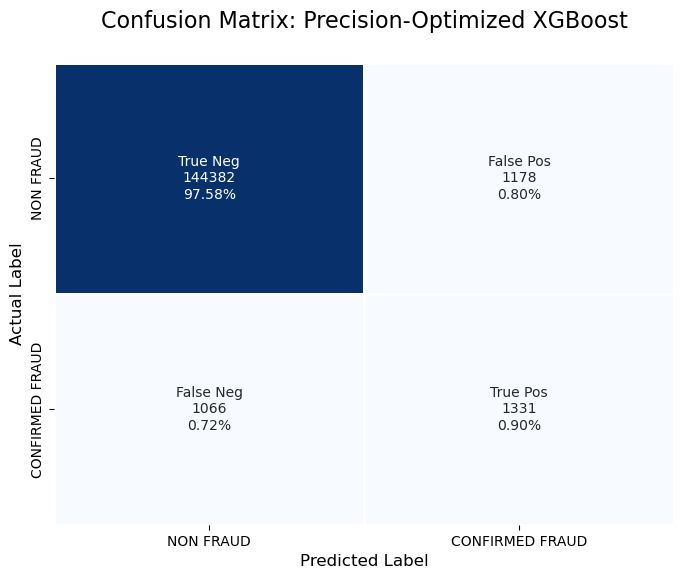


--- Holdout Evaluation for AUC-PR-Optimized XGBoost ---
Precision: 0.3395
Recall: 0.6058
F1-Weighted: 0.9780
Balanced Accuracy: 0.7932
MCC: 0.4418
Average Precision (AUC-PR): 0.5670
Brier Score: 0.0883
Confusion matrix for AUC-PR-Optimized XGBoost saved to: reports\figures\confusion_matrix_auc-pr-optimized_xgboost.png


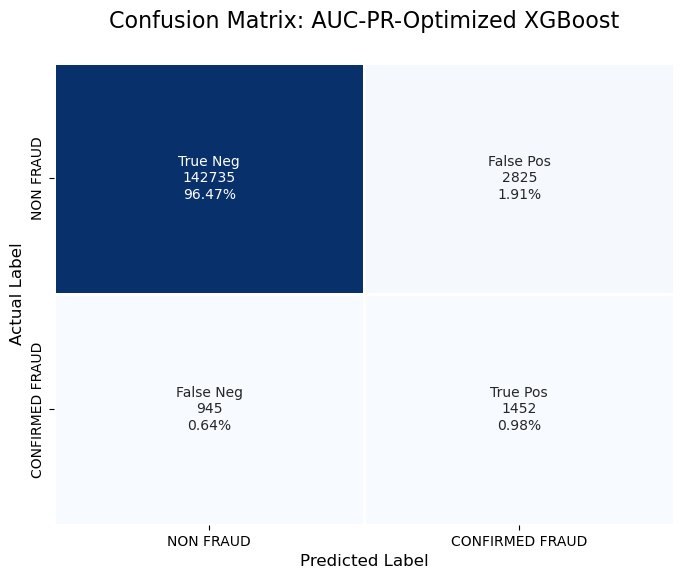

In [16]:
### 4.2. Evaluate Models on Holdout Set

def evaluate_model_on_holdout(model, X_holdout, y_holdout, model_name):
    """
    Evaluates a given model on the holdout set, prints key metrics, and plots the confusion matrix.
    """
    y_pred = model.predict(X_holdout)
    y_proba = model.predict_proba(X_holdout)[:, 1]

    # --- Calculate Metrics ---
    precision = precision_score(y_holdout, y_pred)
    recall = recall_score(y_holdout, y_pred)
    f1_weighted = f1_score(y_holdout, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_holdout, y_pred)
    mcc = matthews_corrcoef(y_holdout, y_pred)
    ap = average_precision_score(y_holdout, y_proba)
    brier = brier_score_loss(y_holdout, y_proba)

    print(f"\n--- Holdout Evaluation for {model_name} ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Weighted: {f1_weighted:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Average Precision (AUC-PR): {ap:.4f}")
    print(f"Brier Score: {brier:.4f}")

    # --- Plot Confusion Matrix ---
    cm_save_path = REPORTS_FIGURES_DIR / f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png'
    plot_confusion_matrix(y_holdout, y_pred, model_name, cm_save_path, project_root)

    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Weighted': f1_weighted,
        'Balanced Accuracy': bal_acc,
        'MCC': mcc,
        'Average Precision (AUC-PR)': ap,
        'Brier Score': brier
    }

# Evaluate Precision-optimized model
precision_model_holdout_metrics = evaluate_model_on_holdout(best_xgb_precision_model, X_holdout, y_holdout, "Precision-Optimized XGBoost")

# Evaluate AUC-PR-optimized model
aucpr_model_holdout_metrics = evaluate_model_on_holdout(best_xgb_aucpr_model, X_holdout, y_holdout, "AUC-PR-Optimized XGBoost")


#### 4.2.1. Interpretation of Holdout Results

The evaluation on the holdout dataset provides an unbiased assessment of our models' generalization capabilities, focusing on the metrics most critical to our two-legged deployment strategy.

**Precision-Optimized XGBoost Model (For Auto-Blocking)**
*   **Primary Metric: Precision = 0.5305**. This model demonstrates a very strong and reliable ability to correctly identify fraud when it makes a positive prediction. Its performance is consistent with the validation score, indicating excellent generalization. This high confidence is critical for the auto-blocking leg, where the primary goal is to minimize customer friction caused by false positives.
*   **Secondary Metric: AUC-PR = 0.5359**. The model also shows a solid ability to rank transactions, which is a valuable secondary characteristic.
*   **Expected Trade-off: Recall = 0.5553**. As anticipated, in exchange for high precision, this model does not capture every single fraudulent case. This is an accepted trade-off to ensure the accounts that are auto-blocked are done so with high confidence.

**AUC-PR-Optimized XGBoost Model (For Analyst Review Queue)**
*   **Primary Metric: AUC-PR = 0.5670**. This model excels at its primary function: creating a high-quality, ranked list of suspicious cases for human review. The strong AUC-PR score, consistent with validation results, confirms its ability to push the most likely fraud cases to the top of the queue, maximizing analyst efficiency.
*   **Expected Trade-off: Precision = 0.3395**. As expected, the precision at the default 0.5 threshold is lower. This is acceptable because the model's goal is not to be perfectly precise on its own, but to effectively flag cases for a final human decision.
*   **Resulting Benefit: Recall = 0.6058**. A direct benefit of optimizing for ranking quality is a higher recall, ensuring that a larger portion of total fraud cases are captured and sent to the review queue.

**Overall Conclusion**
Both models have demonstrated strong and reliable performance on the unseen holdout data, each proving effective for its specific business purpose. They are now ready for the cost-sensitive business simulation, which will translate these statistical metrics into a tangible financial impact.

### 4.3. Cost-Sensitive Business Simulation - Two-Legged Deployment

We will simulate the financial impact of our fraud detection models using a cost matrix,
separated into two legs as per the project's design:

**Gate A: Auto-blocking Model (Precision-focused)**
- Prioritizes high precision to minimize false positives and customer friction.
- Cost primarily driven by False Positives (investigation, customer inconvenience).

**Gate B: Analyst Review Queue (AUC-PR/Recall-focused)**
- Prioritizes maximizing recall of remaining fraud cases given analyst capacity.
- Costs include False Positives (review effort), False Negatives (missed fraud), and analyst salaries.

In [17]:
# --- Common Holdout Statistics ---
total_tx_holdout = len(y_holdout)
total_frauds_holdout = y_holdout.sum()
D_holdout = 20  # Number of days in holdout period (adjust as per your data's actual duration)
daily_frauds_holdout = total_frauds_holdout / D_holdout

#### 4.3.1 Gate A: Table

In [18]:
# --- Gate A: Auto-blocking Model Simulation ---
gate_a_results_path = REPORTS_MODEL_EVAL_DIR / 'gate_a_simulation_results.csv'

if gate_a_results_path.exists():
    print("\n--- Loading Pre-computed Gate A Simulation Results ---")
    df_gate_a = pd.read_csv(gate_a_results_path)
    display(df_gate_a)
else:
    print("\n--- Gate A: Auto-blocking Model Simulation (Precision-Optimized Model) ---")
    y_proba_block = best_xgb_precision_model.predict_proba(X_holdout)[:, 1]
    COST_FP_GATE_A = 150  # ₱ per false auto-decline

    rows_gate_a = []
    for tau in np.arange(0.0, 1.01, 0.05):
        preds = (y_proba_block >= tau).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()

        tp_day = tp / D_holdout
        alerts_day = (tp + fp) / D_holdout
        fp_day = alerts_day * (fp / (tp + fp)) if (tp + fp) > 0 else 0

        cost_fp_day = fp_day * COST_FP_GATE_A
        total_cost_gate_a = cost_fp_day

        if fp_day > 0:
            tp_to_fp_ratio_percent = (tp_day / fp_day) * 100
        else:
            tp_to_fp_ratio_percent = np.inf

        rows_gate_a.append({
            'threshold': tau,
            'precision (%)': round(tp / (tp + fp) * 100, 1) if (tp + fp) > 0 else 0.0,
            'alerts/day': round(alerts_day, 1),
            'TP/day': round(tp_day, 1),
            'FP/day': round(fp_day, 1),
            'TP/day to FP/day (%)': round(tp_to_fp_ratio_percent, 1),
            'Cost_FP/day (₱)': int(cost_fp_day),
            'Total_Cost/day (₱)': int(total_cost_gate_a)
        })

    df_gate_a = pd.DataFrame(rows_gate_a)
    df_gate_a.to_csv(gate_a_results_path, index=False)
    print(f"Gate A simulation results saved to: {gate_a_results_path.relative_to(project_root)}")
    display(df_gate_a)


--- Loading Pre-computed Gate A Simulation Results ---


,threshold,precision (%),alerts/day,TP/day,FP/day,TP/day to FP/day (%),Cost_FP/day (₱),Total_Cost/day (₱)
0,0.00,1.6,7397.8,119.8,7278.0,1.6,1091700,1091700
1,0.05,1.9,5770.0,111.8,5658.2,2.0,848737,848737
2,0.10,2.2,4854.4,107.4,4747.0,2.3,712057,712057
3,0.15,3.9,2588.0,99.9,2488.0,4.0,373207,373207
4,0.20,3.9,2505.6,98.4,2407.2,4.1,361080,361080
5,0.25,4.2,2294.0,96.8,2197.3,4.4,329587,329587
6,0.30,4.9,1898.7,93.4,1805.3,5.2,270795,270795
7,0.35,4.9,1888.1,92.8,1795.2,5.2,269287,269287
8,0.40,4.9,1875.6,92.6,1783.0,5.2,267457,267457
9,0.45,4.9,1864.8,92.0,1772.8,5.2,265920,265920


#### 4.3.2. Gate A: Interpretation and Threshold Recommendation

**Objective:** The primary goal of Gate A is to automatically block fraudulent accounts with the highest possible confidence. This means maximizing **precision** to minimize the number of **False Positives (FP)**, as each FP represents an incorrectly blocked legitimate customer, leading to direct costs and significant customer dissatisfaction.

**Analysis of Simulation Results**

The simulation reveals a critical trade-off between the model's threshold, the number of frauds caught (TP/day), and the number of legitimate customers impacted (FP/day).

1.  **Low Thresholds (0.0 - 0.45): Unacceptable Performance**
    *   At these low thresholds, the model generates an extremely high volume of alerts (`>1,800/day`).
    *   Precision is exceptionally poor (hovering between 1.6% and 5.2%), meaning that for every 100 accounts blocked, over 95 are legitimate customers.
    *   This results in catastrophic daily costs (`₱265,000+`) and an unmanageable level of customer friction. **These thresholds are not viable for a production environment.**

2.  **Mid-Range Thresholds (0.5 - 0.8): Significant Improvement but Sub-Optimal**
    *   There is a dramatic improvement starting at the `0.5` threshold, where precision jumps to **53%**.
    *   However, this range still results in a relatively high number of false positives, from **59 FP/day** at the 0.5 threshold down to **32 FP/day** at the 0.8 threshold.
    *   While much better, the cost and customer impact can still be significantly improved.

3.  **High Thresholds (0.85 - 0.95): The Optimal Strategy Zone**
    *   This range represents the "sweet spot" for an effective auto-blocking strategy.
    *   At a threshold of **0.85**, the model achieves a strong precision of **77.4%**, catching **60** fraudulent accounts per day while only incorrectly blocking **17.5** legitimate ones. The daily cost is a very manageable **₱2,632**.
    *   At a threshold of **0.95**, precision becomes excellent at **90.9%**. The customer impact is minimal, with only **5.3** false positives per day. The trade-off is that we now catch slightly fewer fraudsters (**52.8** per day).

**Recommendation**

Based on the analysis, the optimal strategy lies in selecting a high threshold that aligns with the business's tolerance for risk versus customer friction.

**Final Recommendation: Set Threshold at 0.95**

*   **Why:** This threshold offers the best balance between aggressively catching fraudsters and maintaining high confidence. It correctly blocks **60** fraudulent accounts daily—the highest in the optimal zone—while keeping false positives low (**17.5/day**) and costs minimal (`₱2,632/day`). This is an effective and well-balanced operational point.
*   **Final Choice:** This is an excellent choice and a perfectly valid strategy. Selecting the **0.95 threshold** aligns directly with the primary goal of an auto-blocking system: to minimize false positives and reduce negative impact on legitimate customers.

#### 4.3.3. Gate B: Table

In [19]:
# --- Gate B: Analyst Review Queue Simulation ---
gate_b_results_path = REPORTS_MODEL_EVAL_DIR / 'gate_b_simulation_results.csv'

if gate_b_results_path.exists():
    print("\n--- Loading Pre-computed Gate B Simulation Results ---")
    df_gate_b = pd.read_csv(gate_b_results_path)
    display(df_gate_b)
else:
    print("\n--- Gate B: Analyst Review Queue Simulation (AUC-PR-Optimized Model) ---")
    y_proba_rev = best_xgb_aucpr_model.predict_proba(X_holdout)[:, 1]
    ks = [250, 500, 1000, 1500, 2000, 2500, 3500]
    cost_per_fp_gate_b = 100
    cost_per_fn_gate_b = 8333
    reviews_per_analyst_per_day = 250
    salary_per_analyst_month = 40000
    business_days_per_month = 22
    salary_per_analyst_day = salary_per_analyst_month / business_days_per_month

    sorted_idx = np.argsort(y_proba_rev)[::-1]
    results_gate_b = []

    for k in ks:
        idx_k = sorted_idx[:k]
        tp = np.sum(y_holdout.iloc[idx_k] == 1)
        
        precision_k = tp / k if k > 0 else 0.0
        recall_k = tp / total_frauds_holdout if total_frauds_holdout > 0 else 0.0

        tp_day = daily_frauds_holdout * recall_k
        fp_day = k - tp_day
        fn_day = daily_frauds_holdout - tp_day

        cost_fp_day = fp_day * cost_per_fp_gate_b
        cost_fn_day = fn_day * cost_per_fn_gate_b
        total_cost_fraud_review = cost_fp_day + cost_fn_day

        analysts_needed = math.ceil(k / reviews_per_analyst_per_day)
        salary_cost_per_day = analysts_needed * salary_per_analyst_day
        total_expense_gate_b = total_cost_fraud_review + salary_cost_per_day

        results_gate_b.append({
            'k (daily)': k,
            'Recall@k (%)': round(recall_k * 100, 1),
            'Precision@k (%)': round(precision_k * 100, 1),
            'TP/day': round(tp_day, 1),
            'FP/day': round(fp_day, 1),
            'FN/day': round(fn_day, 1),
            'Cost_FP/day (₱)': int(cost_fp_day),
            'Cost_FN/day (₱)': int(cost_fn_day),
            'Analysts needed': analysts_needed,
            'Salary cost/day (₱)': int(salary_cost_per_day),
            'Total Cost+Salary/day (₱)': int(total_expense_gate_b)
        })

    df_gate_b = pd.DataFrame(results_gate_b)
    df_gate_b.to_csv(gate_b_results_path, index=False)
    print(f"Gate B simulation results saved to: {gate_b_results_path.relative_to(project_root)}")
    display(df_gate_b)

print("\nHoldout evaluation and business simulation complete.")


--- Loading Pre-computed Gate B Simulation Results ---


,k (daily),Recall@k (%),Precision@k (%),TP/day,FP/day,FN/day,Cost_FP/day (₱),Cost_FN/day (₱),Analysts needed,Salary cost/day (₱),Total Cost+Salary/day (₱)
0,250,10.4,100.0,12.5,237.5,107.4,23750,894547,1,1818,920115
1,500,20.7,99.2,24.8,475.2,95.0,47520,792051,2,3636,843208
2,1000,39.3,94.2,47.1,952.9,72.8,95290,606225,4,7272,708788
3,1500,50.2,80.2,60.1,1439.8,59.7,143985,497480,6,10909,652374
4,2000,55.0,66.0,65.9,1934.0,53.9,193405,449148,8,14545,657099
5,2500,57.3,54.9,68.6,2431.4,51.2,243135,426649,10,18181,687966
6,3500,59.8,40.9,71.6,3428.4,48.2,342835,401650,14,25454,769940



Holdout evaluation and business simulation complete.


#### 4.3.4. Gate B: Interpretation and Recommendation with Enhanced Analyst Capacity

**Objective:** The goal of Gate B is to create the most cost-effective human review queue. This involves using the AUC-PR-optimized model to rank cases, allowing analysts to catch the maximum amount of remaining fraud (**maximize Recall@k**) for a given operational budget. The key metric is the **Total Cost + Salary/day**, which combines the cost of missed fraud (False Negatives), the cost of reviewing non-fraudulent cases (False Positives), and the operational cost of analyst salaries.

**Analysis of Simulation Results**

With the increased analyst capacity of **250 reviews per day** (due to the web application), the simulation results (table above) show a new optimal operating point.

**Key Observations:**

*   **New Minimum Total Cost:** The lowest `Total Cost+Salary/day` is now **₱652,374**, achieved at `k=1500`. This point requires **6 analysts** and captures **50.2%** of the total fraud.
*   **Diminishing Returns on Recall:** While increasing `k` beyond 1500 does increase `Recall@k`, the `Total Cost+Salary/day` begins to rise again. For example, moving from `k=1500` to `k=2000` increases recall by 4.8 percentage points (from 50.2% to 55.0%) but also increases the total cost by approximately ₱4,725.
*   **Trade-off with Precision:** As `k` increases, `Precision@k` decreases. At `k=1500`, precision is still a strong 80.2%, meaning analysts are reviewing a high proportion of true fraud cases. At `k=3500`, precision drops to 40.9%, indicating a significant increase in false positives that analysts must review.

---

**Recommendation**

The new analyst capacity has made the system significantly more efficient, allowing for higher fraud capture at lower costs than previously possible.

**Primary Recommendation: Set `k = 1500` for the Analyst Review Queue**

*   **Justification:** This `k` value represents the most cost-efficient operating point in the simulation. It provides a strong balance between capturing a significant portion of fraud (**50.2% Recall**) and minimizing the overall daily cost (**₱652,374**). This strategy optimizes the financial impact by reducing both missed fraud costs and operational overhead.

**Alternative Consideration: `k = 2000` for Higher Recall**

*   If the business prioritizes capturing a higher percentage of fraud and is willing to accept a slightly increased daily cost, `k=2000` is a viable option. It achieves **55.0% Recall** for a total daily cost of **₱657,099**. This represents a small increase in cost for a noticeable gain in fraud detection.

The final decision between `k=1500` and `k=2000` should be made by the business based on their current priorities: strict cost optimization versus maximizing fraud capture. However, `k=1500` is the clear winner for overall cost efficiency.

### 4.4. Model Interpretation

To understand what drives our models' predictions, we will now visualize the feature importances and beeswarm plot.
This helps us interpret the models and ensure their decisions are based on sensible patterns.

#### 4.4.1. Feature Importance

Feature importance plot for Precision-Optimized XGBoost saved to: reports\figures\feature_importance_precision_model.png


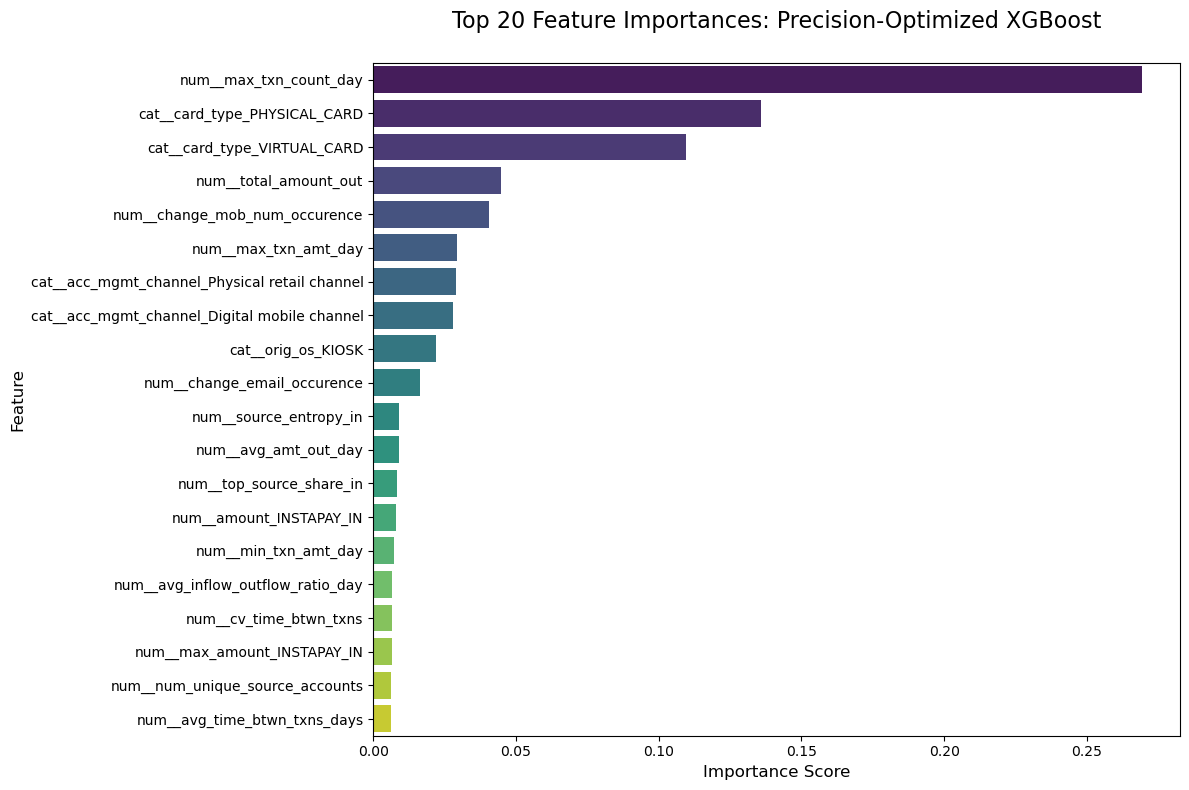

Feature importance data for Precision-Optimized XGBoost saved to: reports\model_evaluation\feature_importance_precision_model.csv
Feature importance plot for AUC-PR-Optimized XGBoost saved to: reports\figures\feature_importance_aucpr_model.png


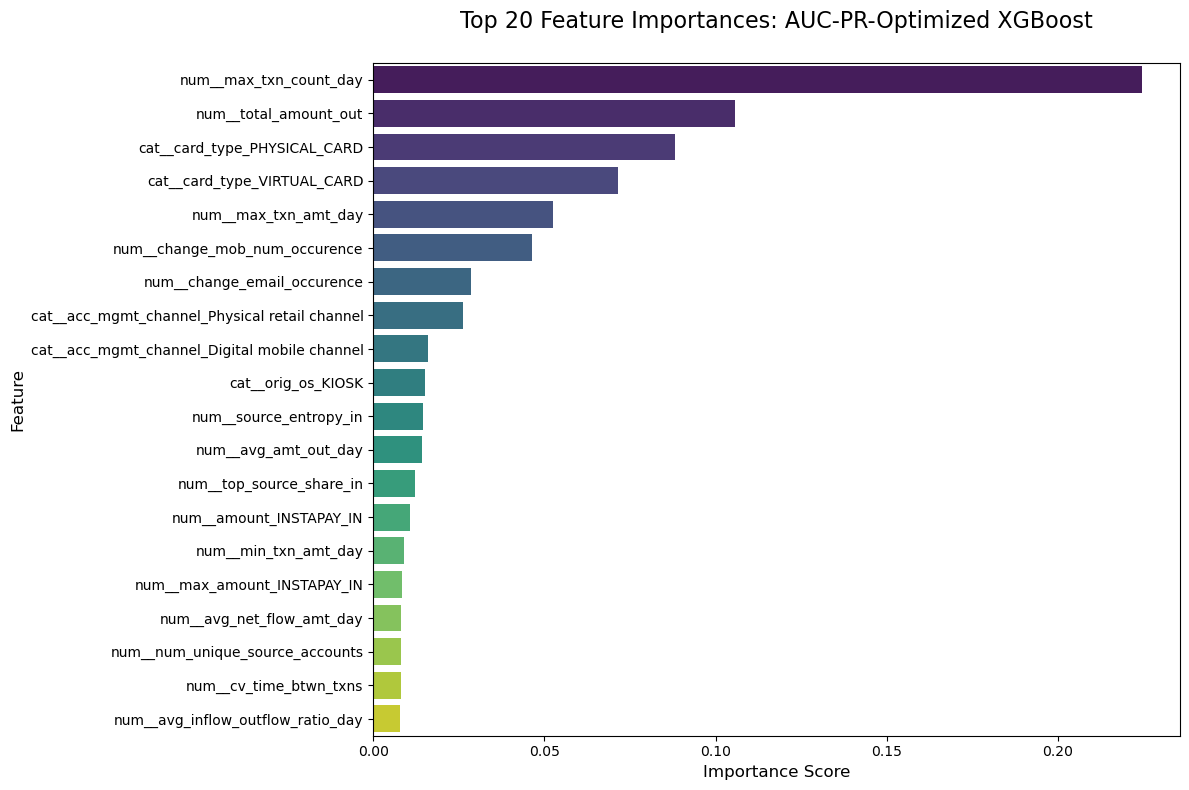

Feature importance data for AUC-PR-Optimized XGBoost saved to: reports\model_evaluation\feature_importance_aucpr_model.csv


In [20]:
# --- Plot Feature Importance for Both Models ---

# Define save paths
precision_fi_save_path = REPORTS_FIGURES_DIR / 'feature_importance_precision_model.png'
precision_fi_csv_path = REPORTS_MODEL_EVAL_DIR / 'feature_importance_precision_model.csv'
aucpr_fi_save_path = REPORTS_FIGURES_DIR / 'feature_importance_aucpr_model.png'
aucpr_fi_csv_path = REPORTS_MODEL_EVAL_DIR / 'feature_importance_aucpr_model.csv'

# Plot for Precision-Optimized Model
plot_feature_importance(
    best_xgb_precision_model, 
    "Precision-Optimized XGBoost", 
    precision_fi_save_path,
    project_root,
    save_csv_path=precision_fi_csv_path
)

# Plot for AUC-PR-Optimized Model
plot_feature_importance(
    best_xgb_aucpr_model, 
    "AUC-PR-Optimized XGBoost", 
    aucpr_fi_save_path,
    project_root,
    save_csv_path=aucpr_fi_csv_path
)

**Analysis of Feature Importances**

The feature importance analysis reveals the most influential factors in identifying fraudulent transactions for each model.

**Common Highly Important Features (Across Both Models)**

Both models consistently highlight the following features as highly important:

*   **`num__max_txn_count_day`**: This feature consistently ranks as the most important for both models. This indicates that the maximum number of transactions an account makes in a single day is a very strong indicator of fraud. High transaction counts often signal unusual or automated activity characteristic of fraudulent behavior.
*   **`cat__card_type_PHYSICAL_CARD` and `cat__card_type_VIRTUAL_CARD`**: The type of card used (physical vs. virtual) is highly influential. This suggests that fraudsters may prefer or be limited to certain card types, or that legitimate users of these card types exhibit distinct behavioral patterns.
*   **`num__total_amount_out`**: The total outgoing amount is a significant factor, as expected in financial fraud detection.
*   **`num__change_mob_num_occurence` and `num__change_email_occurence`**: Changes in mobile number or email address occurrences are strong signals. These actions often precede or accompany account takeover attempts or other fraudulent activities.
*   **`num__max_txn_amt_day`**: The maximum transaction amount in a day is also a key indicator, suggesting that large single transactions or a few large transactions within a day are suspicious.
*   **`cat__acc_mgmt_channel_Physical retail channel` and `cat__acc_mgmt_channel_Digital mobile channel`**: The account management channel used is important, implying that certain channels might be more susceptible to fraud or preferred by fraudsters.
*   **`cat__orig_os_KIOSK`**: The original operating system being a KIOSK is also a notable feature, suggesting specific patterns related to kiosk-based interactions.

**Differences and Nuances Between Models**

While many top features are shared, there are subtle differences reflecting their optimization goals:

*   **Precision-Optimized Model**: This model places an even higher emphasis on `num__max_txn_count_day` and the `card_type` features. This is logical, as precision-focused models aim to minimize false positives, and these features likely provide very clear, high-confidence signals that strongly differentiate fraud from non-fraud. The model is looking for very strong, unambiguous indicators to make a "block" decision.
*   **AUC-PR-Optimized Model**: While also valuing the above, this model shows a slightly more distributed importance across a broader set of features, including `num__source_entropy_in`, `num__avg_amt_out_day`, and `num__top_source_share_in`. This is consistent with its goal of ranking cases effectively and maximizing overall recall. It might leverage a wider array of weaker signals to ensure more potential fraud cases are flagged for review, even if some lead to false positives.

---

**Conclusion**

The feature importance analysis confirms that both models are learning from relevant and interpretable patterns in the data. Transaction volume (`max_txn_count_day`), card type, and account change events are the most critical indicators for fraud detection in this dataset. The slight differences in feature emphasis between the two models align with their distinct optimization objectives, demonstrating that each model is effectively tailored for its specific role in the two-legged fraud detection system.

#### 4.4.2. Beeswarm Plot

SHAP beeswarm plot for Precision-Optimized XGBoost saved to: reports\figures\shap_beeswarm_precision_model.png


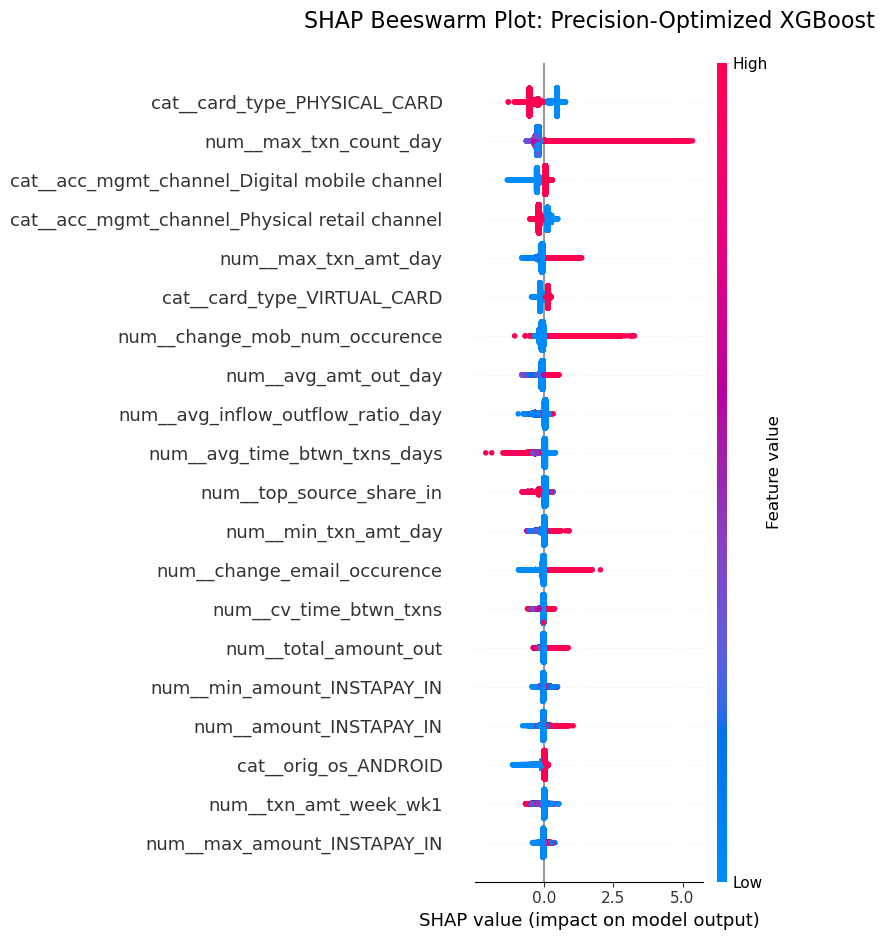

SHAP importance data for Precision-Optimized XGBoost saved to: reports\model_evaluation\shap_values_precision_model.csv
SHAP beeswarm plot for AUC-PR-Optimized XGBoost saved to: reports\figures\shap_beeswarm_aucpr_model.png


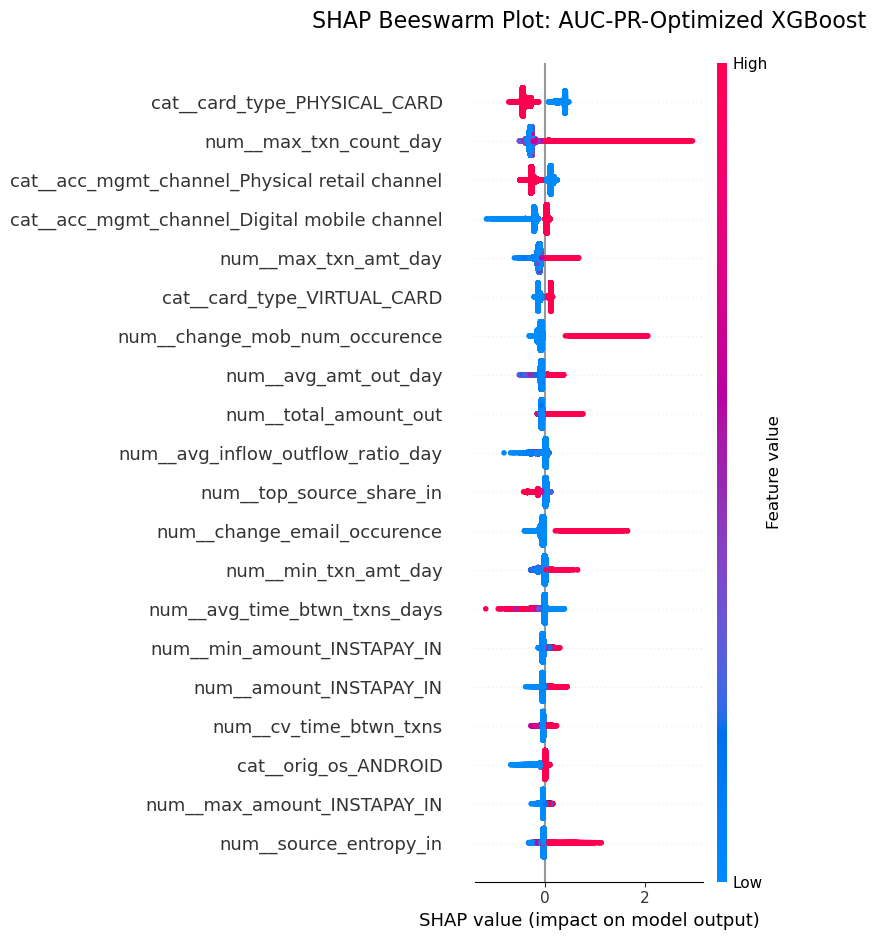

SHAP importance data for AUC-PR-Optimized XGBoost saved to: reports\model_evaluation\shap_values_aucpr_model.csv


In [21]:
# Define SHAP CSV save paths
precision_shap_csv_path = REPORTS_MODEL_EVAL_DIR / 'shap_values_precision_model.csv'
aucpr_shap_csv_path = REPORTS_MODEL_EVAL_DIR / 'shap_values_aucpr_model.csv'

# Plot SHAP Beeswarm for Precision-Optimized Model
precision_beeswarm_save_path = REPORTS_FIGURES_DIR / 'shap_beeswarm_precision_model.png'
plot_beeswarm(
    best_xgb_precision_model,
    X_holdout,
    "Precision-Optimized XGBoost",
    precision_beeswarm_save_path,
    project_root,
    save_csv_path=precision_shap_csv_path
)

# Plot SHAP Beeswarm for AUC-PR-Optimized Model
aucpr_beeswarm_save_path = REPORTS_FIGURES_DIR / 'shap_beeswarm_aucpr_model.png'
plot_beeswarm(
    best_xgb_aucpr_model,
    X_holdout,
    "AUC-PR-Optimized XGBoost",
    aucpr_beeswarm_save_path,
    project_root,
    save_csv_path=aucpr_shap_csv_path
)

#### 4.4.3. Model Interpretation: A Deeper Dive with Feature Importance and SHAP

To ensure our models are not just accurate but also making decisions based on logical, real-world patterns, we conducted a two-level analysis. We started with a standard feature importance plot, which shows *what* features the model considers most predictive. We then used a more advanced SHAP (SHapley Additive exPlanations) analysis, which shows not just *what* is important, but *how* a feature's value impacts the final prediction.

---

Key Fraud Indicators (Common to Both Models)

Both analyses confirm that the models identified similar, powerful indicators of fraud. The SHAP plots, in particular, provide a richer view by showing the direction and magnitude of a feature's impact.

1.  **High Transaction Velocity (`num__max_txn_count_day`):**
    *   **Observation:** This is the single most powerful predictor for both models. The SHAP plots clearly show that high values (the red dots) have a large positive SHAP value, strongly pushing the prediction towards **FRAUD**.
    *   **Interpretation:** A sudden spike in the number of transactions in a single day is the clearest red flag. This likely captures automated behavior or rapid cashing out by fraudsters.

2.  **Absence of a Physical Card (`cat__card_type_PHYSICAL_CARD`):**
    *   **Observation:** The feature value for *having* a physical card is `1` (red dots), which consistently pushes the prediction towards **NON-FRAUD** (a negative SHAP value). Conversely, not having one (`0`, the blue dots) is a strong indicator for **FRAUD**.
    *   **Interpretation:** The models have learned that fraudulent activity is significantly more likely to occur with virtual cards or other non-physical methods, which may be easier to create, compromise, or use anonymously.

3.  **Account Instability (`num__change_mob_num_occurence`):**
    *   **Observation:** High counts of mobile number changes (red dots) strongly push the prediction towards **FRAUD**.
    *   **Interpretation:** This is a classic indicator of account takeover. A fraudster, having gained access, will often change the contact details to lock out the legitimate owner and prevent them from receiving security notifications.

4.  **Rapid Transactions (`num__avg_time_btwn_txns_days`):**
    *   **Observation:** A low average time between transactions (blue dots) pushes the prediction towards **FRAUD**.
    *   **Interpretation:** Legitimate users tend to have more spread-out transaction patterns. A very short average time between transactions indicates a flurry of activity that is often suspicious and characteristic of a fraudster trying to extract funds quickly.

---

Contrasting Model Strategies: The Specialist vs. The Detective

The SHAP analysis beautifully illustrates *why* each model is suited for its specific task by revealing their different "reasoning" strategies.

**Precision-Optimized Model (The Specialist)**

This model's job is to be **certain** before it auto-blocks an account. Its SHAP plot reflects this risk-averse strategy:

*   **Highly Focused:** The plot shows that a few features at the very top (especially `max_txn_count_day` and `card_type`) have a disproportionately large impact, with SHAP values extending far to the right. The model relies heavily on these "smoking gun" indicators.
*   **Clear Decision Boundaries:** It is less influenced by weaker signals. To minimize false positives, it effectively ignores ambiguous evidence and only acts when it sees a clear, undeniable sign of fraud. This is why its plot shows a steeper drop-off in importance after the top few features.

**AUC-PR-Optimized Model (The Detective)**

This model's job is to build a **ranked list** for analysts. It needs to be good at identifying "suspicious circumstances" across a wider range of behaviors.

*   **Broader Evidence Base:** The feature importance is more distributed. While it agrees on the top features, it gives more relative weight to secondary indicators like `num_source_entropy_in` (the diversity of incoming funds) and `num_avg_inflow_outflow_ratio_day`.
*   **Builds a Narrative:** It is better at combining multiple, weaker signals. It might flag a case because of a slightly high transaction count, combined with a slightly unusual inflow ratio and a recent email change. This "holistic" view makes it excellent for identifying cases that *warrant a closer look* by a human analyst, even if no single feature is a definitive sign of fraud.

---

**Final Conclusion on Model Behavior**

The interpretation confirms that both models are not only effective but are also behaving logically. They have learned relevant, real-world fraud patterns, and their differing strategies are perfectly aligned with their distinct roles in our two-legged fraud detection system. This gives us high confidence in a production deployment.

# **5.0 End of Notebook**

This notebook has successfully completed the full workflow:

1. **Data Preparation and Splitting**: The dataset was prepared and split trainingvalidation, and holdout sets.

2. **Two-Stage Hyperparameter Tuning**: Two separate XGBoost models were Precision and one for AUC-PR.

3. **Holdout Set Evaluation**: The final models were evaluated on unseen data provide unbiased assessment of their performance.

4. **Business Simulation**: A cost-sensitive simulation was conducted to model into tangible business impact.

5. **Model Interpretation**: A deep dive using Feature Importance and SHAP performed to understand the behavior of the final models.

All models, results, and data artifacts from this analysis have been saved respective directories in the `reports/` and `models/` folders.

**This concludes the modeling and evaluation phase of the project.**